# fastMRI

In [14]:
ll -h /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5

-rw-rw-r-- 1 ubuntu 91M May 31 18:39 /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5


In [15]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [17]:
import cs230_project_utilities as utils

# Loading the data

In [20]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
dataset_directory = '/home/ubuntu/cs230/data/fastmri/raw'

In [21]:
def find_dataset_files(dataset_directory):
    # Find .h5 and .txt files in `dataset_directory`
    # Assuming at most one name.h5 and one name.txt file in `dataset_directory`.
    h5_file_pattern = os.path.join(dataset_directory, '*.h5')
    text_file_pattern = os.path.join(dataset_directory, '*.txt')
    h5_paths = glob.glob(h5_file_pattern)
    text_paths = glob.glob(text_file_pattern)
    print('Found {} .h5 files and {} .txt files.'.format(len(h5_paths), len(text_paths)))
    
    # Merge .h5 and .txt paths into one data structure: a dict where key is filename
    # without extension and value is dict {'h5': h5_path, 'text': text_path}.
    get_filename = lambda path: os.path.splitext(os.path.basename(path))[0]
    files = {}
    for path in h5_paths:
        filename = get_filename(path)
        files[filename] = {'h5': path}
    for path in text_paths:
        filename = get_filename(path)
        files[filename]['text'] = path
      
    return files

In [22]:
# Find all the files in our dataset
files = find_dataset_files(dataset_directory)

Found 1 .h5 files and 0 .txt files.


In [26]:
files['file1000000']['h5']

'/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5'

In [27]:
# Load example files
example = files['file1000000']
print(example)

{'h5': '/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5'}


In [32]:
h5 = example['h5']

In [43]:
# Handle .h5 files

def inspect_h5_file(path):
    with h5py.File(path, 'r') as f:
        # Looks like .h5 files are like dictionaries
        print('Found keys: {}'.format(f.keys()))
        
        # Let's find all the nested keys
        print('\nFinding nested keys...')
        show_keys_for_h5_file(path)
        
        # Unwrap the data stored in the keys
        # known keys: 'clasificacion', 'images', 'kspace/mag', 'kspace/phase'
        print('\nUnwrapping data at known keys...')
        ismrmrd_header = f['ismrmrd_header']
        kspace = f['kspace']
        reconstruction_esc = f['reconstruction_esc']
        reconstruction_rss = f['reconstruction_rss']
        print(ismrmrd_header)
        print(kspace)
        print(reconstruction_esc)
        print(reconstruction_rss)

def show_keys_for_h5_file(path):
    '''
    Convenience function for printing the nested keys in an
    .h5 file.
    '''
    def print_nested_keys(key, value):
        print(key)
        for k, v in value.attrs.iteritems():
            print('{}: {}'.format(key, val))

    with h5py.File(path, 'r') as f:
        f.visititems(print_nested_keys)
        
def read_h5_file(path):
    '''
    Reads a .h5 file from `path`, unwrapping data stored in the known
    keys: 'clasificacion', 'images', 'kspace/mag', 'kspace/phase'.
    '''
    with h5py.File(path, 'r') as f:
        metadata = f['ismrmrd_header'].value
        kspace = f['kspace'].value
        reconstruction_esc = f['reconstruction_esc'].value
        reconstruction_rss = f['reconstruction_rss'].value
        
#     # Convert to float32 and scale data to [0, 1]
#     images = images.astype(np.float32)
#     images -= images.min(axis=(1, 2), keepdims=True)
#     images /= images.max(axis=(1, 2), keepdims=True)
    print(kspace.shape)
    
#     # Additional conversion scaling here with magnitude data.
#     # Most ML and scientific frameworks expect data to be in [0, 1].
#     magnitude = magnitude.astype(np.float32)
#     magnitude -= magnitude.min(axis=(1, 2), keepdims=True)
#     magnitude /= magnitude.max(axis=(1, 2), keepdims=True)
    
#     phase = phase.astype(np.float32)
    # Don't scale phase (it represents an angle, so it's always in [0, pi])
    
    return {'metadata': metadata,
            'kspace': kspace,
            'reconstruction_esc': reconstruction_esc,
            'reconstruction_rss': reconstruction_rss}
    
# Handle .txt files

def inspect_text_file(path):
    with open(path, 'rb') as f:
        print(f.read())


In [44]:
# Let's look at a single .h5 file
inspect_h5_file(h5)

Found keys: [u'ismrmrd_header', u'kspace', u'reconstruction_esc', u'reconstruction_rss']

Finding nested keys...
ismrmrd_header
kspace
reconstruction_esc
reconstruction_rss

Unwrapping data at known keys...
<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (35, 640, 368), type "<c8">
<HDF5 dataset "reconstruction_esc": shape (35, 320, 320), type "<f4">
<HDF5 dataset "reconstruction_rss": shape (35, 320, 320), type "<f4">


# Visualizing the data

In [40]:
ismrmrd_header

'<?xml version="1.0"?>\n<ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xs="http://www.w3.org/2001/XMLSchema" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">\n\t<studyInformation>\n\t\t<studyTime>09:38:43</studyTime>\n\t</studyInformation>\n\t<measurementInformation>\n\t\t<measurementID>67041_36245722_36245731_3604</measurementID>\n\t\t<patientPosition>FFS</patientPosition>\n\t\t<protocolName>COR</protocolName>\n\t\t<frameOfReferenceUID>1.3.12.2.1107.5.2.43.67041.1.20180315092920748.0.0.0</frameOfReferenceUID>\n\t</measurementInformation>\n\t<acquisitionSystemInformation>\n\t\t<systemVendor>SIEMENS</systemVendor>\n\t\t<systemModel>Prisma_fit</systemModel>\n\t\t<systemFieldStrength_T>2.893620</systemFieldStrength_T>\n\t\t<relativeReceiverNoiseBandwidth>0.793000</relativeReceiverNoiseBandwidth>\n\t\t<receiverChannels>15</receiverChannels>\n\t\t<coilLabel>\n\t\t\t<coilNumber>42</coilNumber>\n\t\t\t<coilName>TxR

In [89]:
# Finally, we can see the raw data
h5_data = read_h5_file(h5)
print(h5_data.keys())

metadata = h5_data['metadata']
kspace = h5_data['kspace']
reconstruction_esc = h5_data['reconstruction_esc']
reconstruction_rss = h5_data['reconstruction_rss']

# (Note: shape of magnitude and phase are different from image)
print(kspace.shape, reconstruction_esc.shape, reconstruction_rss.shape)

(35, 640, 368)
['reconstruction_esc', 'reconstruction_rss', 'kspace', 'metadata']
((35, 640, 368), (35, 320, 320), (35, 320, 320))


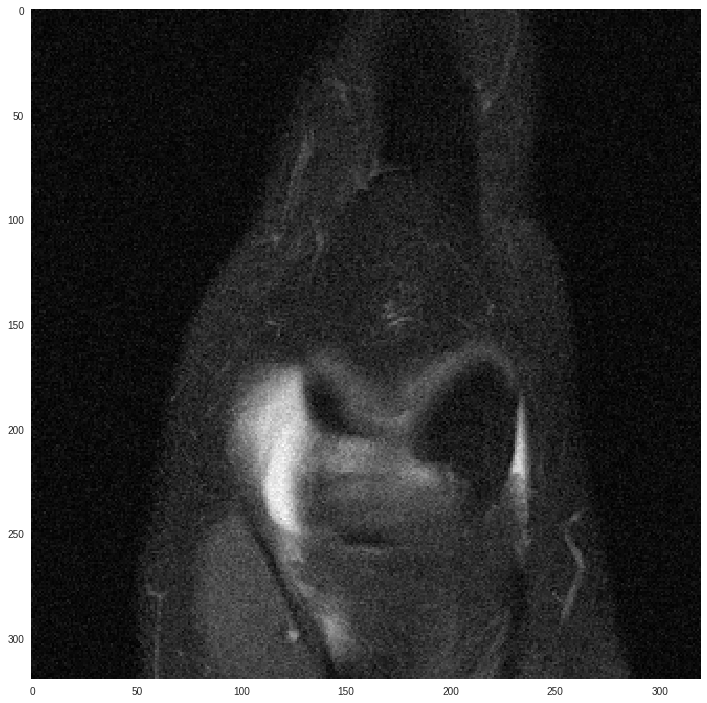

In [90]:
utils.plot.imshowgray(reconstruction_esc[10])

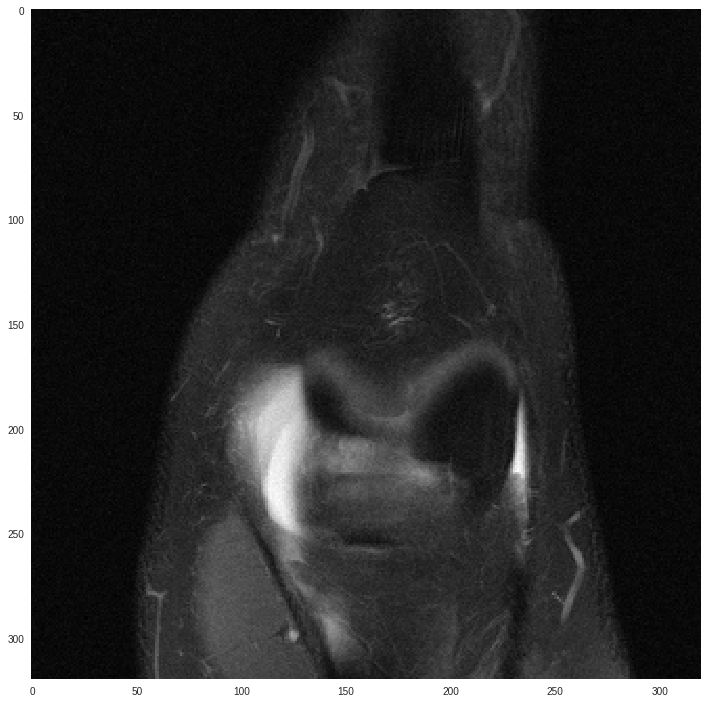

In [91]:
utils.plot.imshowgray(reconstruction_rss[10])

In [92]:
fft_raw = kspace[10]

In [93]:
fft_raw.real.max()

0.004381507

In [94]:
fft = fft_raw.real + 1j * fft_raw.imag

In [95]:
fft_raw.shape

(640, 368)

In [88]:
#### fft = np.reshape(fft_raw, (fft_raw.shape[1], fft_raw.shape[1], -1))
fft.shape

(640, 368)

In [60]:
fft_raw.shape

(640, 368)

In [ ]:
utils.plot.imshowgray(reconstruction_esc[10])

PSNR of reconstrution: 144.464960819


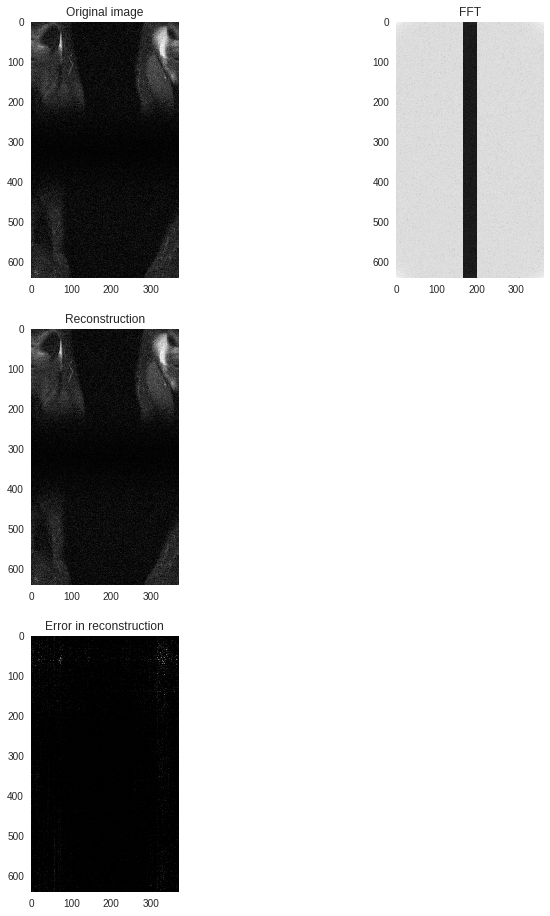

In [99]:
# Function from MRI_reconstruction_example.ipynb
utils.reconstruction_demo.reconstruct_image_from_fully_sampled_fourier_transform(np.fft.ifft2(kspace[10]))

PSNR of reconstrution: 34.2621596248
Mask preserves 54.33% of FFT coefficients


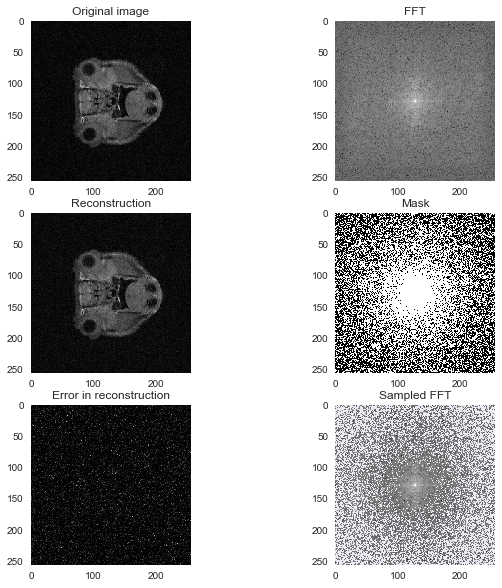

In [20]:
# Load masks for seeing how reconstruction works with sampled k-space data.

def load_mask_and_pdf_data():
    data = np.load('brain.npz')
    # brain_image is complex-valued
    brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf = (data['im'], data['mask_unif'],
        data['mask_vardens'], data['pdf_unif'], data['pdf_vardens'])
    return brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf

_, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf = load_mask_and_pdf_data()

# Get center crop of mask because this data has smaller shape
image = images[0]
mask = np.ones_like(image)
mask = vardens_mask[image.shape[0]//2:-image.shape[0]//2, image.shape[0]//2:-image.shape[0]//2]
pdf = vardens_pdf[image.shape[0]//2:-image.shape[0]//2, image.shape[0]//2:-image.shape[0]//2]

# Run reconstruction
utils.reconstruction_demo.reconstruct_image_from_undersampled_fourier_transform(image, mask, pdf)

### Plot magnitude of FFT

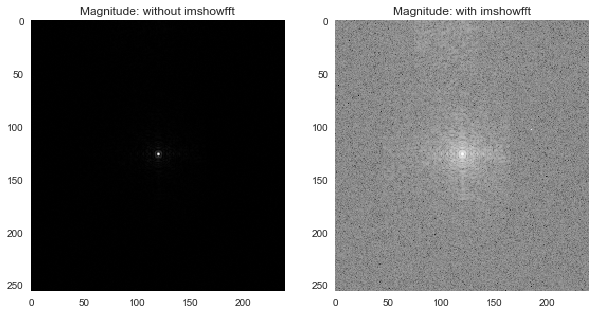

In [21]:
plt.rcParams['figure.figsize'] = (10, 10)

# Should use imshowfft (which takes log of magnitude) here because without it,
# can't visualize the higher frequencies (FFT coefficients are mostly high
# around the center == lower frequencies).

# Plot magnitude
plt.subplot(1, 2, 1)
plt.title('Magnitude: without imshowfft')
utils.plot.imshowgray(magnitude[0])

plt.subplot(1, 2, 2)
plt.title('Magnitude: with imshowfft')
utils.plot.imshowfft(magnitude[0])

### Plot phase of FFT

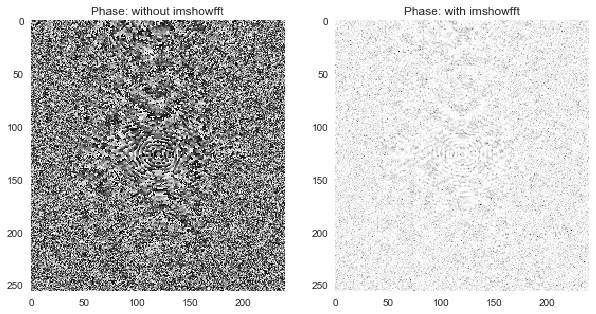

In [22]:
# Plot phase (probably don't want to use imshowfft for phase)
plt.subplot(1, 2, 1)
plt.title('Phase: without imshowfft')
utils.plot.imshowgray(phase[0])

plt.subplot(1, 2, 2)
plt.title('Phase: with imshowfft')
utils.plot.imshowfft(phase[0])

# Reconstruct an image from magnitude and phase

Error in FFT magnitude: 3.13614806093e-20
Error in FFT phase: 6.27353347621e-07


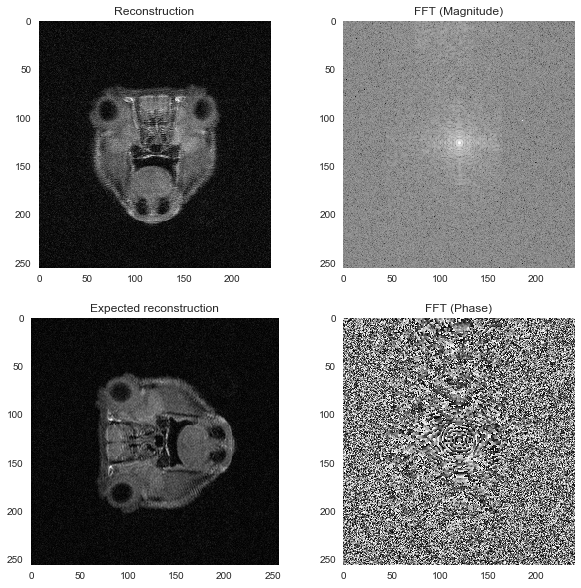

In [23]:
# Construct FFT (k-space data) from magnitude and phase
fft = magnitude[0] * np.exp(1j * phase[0])

# Take the inverse FFT
ifft = utils.signal_processing.ifft_2D_centered(fft)

plt.subplot(2, 2, 1)
plt.title('Reconstruction')
utils.plot.imshowgray(np.abs(ifft))

plt.subplot(2, 2, 2)
plt.title('FFT (Magnitude)')
utils.plot.imshowfft(np.abs(fft))

plt.subplot(2, 2, 3)
plt.title('Expected reconstruction')
utils.plot.imshowgray(images[0])

plt.subplot(2, 2, 4)
plt.title('FFT (Phase)')
utils.plot.imshowgray(np.angle(fft))

# Note: shape of magnitude and phase are different from image.
# Because of this, the reconstruction shape is different from the
# image shape and so we can't compare the image and reconstruction directly.
# How will we solve this?

# This check to make sure we are correctly combining magnitude and phase to construct the full, complex-valued FFT.
print('Error in FFT magnitude: {}'.format(utils.signal_processing.mean_square_error(np.abs(fft), magnitude[0])))
print('Error in FFT phase: {}'.format(utils.signal_processing.mean_square_error(np.angle(fft), phase[0])))
